### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [3]:
#import things
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from scipy.stats import laplace
import corner
import numdifftools as nd
from scipy.stats import uniform
from scipy import stats
import numpy as np
import emcee

## Part 1

In [7]:
#1 same as HW3
#read in the data
data=np.load('../../../homeworks/hw_data/hw8_data_1.npy')
#get the coulumn names
c = data.dtype.names
print(c)
#u-g
ug=np.subtract(data['u'],data['g'])
#g-r
gr=np.subtract(data['g'],data['r'])
#r-i
ri=np.subtract(data['r'],data['i'])
#i-z
iz=np.subtract(data['i'],data['z'])
#redshift
red=data['redshift']
rederr=data['redshift_err']
#spectral
specs=data['specClass']
#print(spec)

#counting 
count1=0
for i in range(len(specs)):
    if specs[i]=="QSO":
        count1+=1
print('There are',count1,'QSO')

count2=0
for i in range(len(specs)):
    if specs[i]=="GALAXY":
        count2+=1
print('There are',count2,'Galaxies')

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
There are 7192 QSO
There are 42808 Galaxies


## Part 2

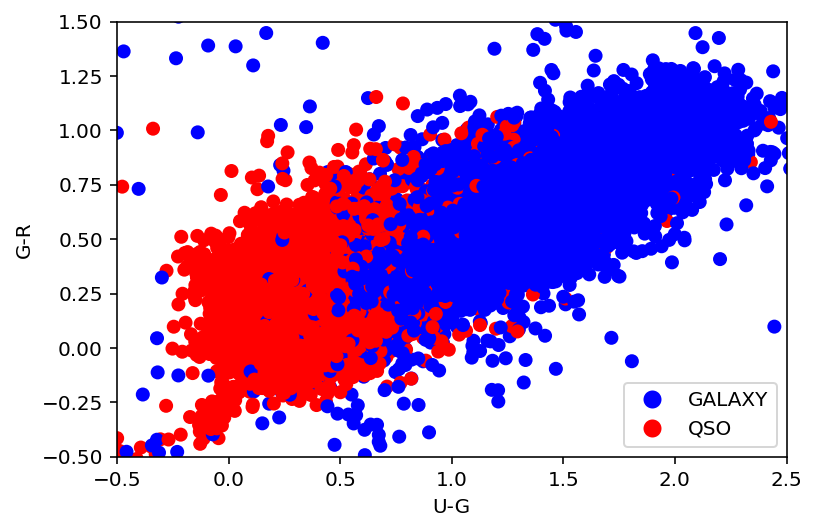

In [8]:
# Color mapping
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
color_map = {'GALAXY': 'blue', 'QSO': 'red'}

# Create the scatter plot
plt.scatter(ug, gr, c=[color_map[spec] for spec in specs])
plt.xlabel("U-G")
plt.ylabel("G-R")
#plt.title("")
plt.xlim(-.5,2.5)
plt.ylim(-.5,1.5)
#making a legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='GALAXY',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='QSO',
                          markerfacecolor='r', markersize=10)]
plt.legend( handles=legend_elements)

## Part 3

In [11]:
#stacking 
#colors1=np.array(np.meshgrid(ug,gr)).T.reshape(-1,2)
colors = np.vstack((ug, gr, ri, iz)).T
print(colors)
#create array of labels
lables=[]
for i in range(len(specs)):
    if specs[i]=="QSO":
        lables.append(1)
    else:
        lables.append(0)
#print(lables)

[[0.57029 0.04138 0.02815 0.28811]
 [2.04144 0.98938 0.48183 0.3653 ]
 [1.84529 1.0416  0.45719 0.39585]
 ...
 [0.63545 0.08109 0.10749 0.26389]
 [0.30073 0.16404 0.05842 0.01814]
 [0.5429  0.13127 0.16219 0.10183]]


In [12]:
#splitting the data into test and train
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X=colors
y=lables
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
print(Xtrain)

[[ 1.92299  0.86976  0.41525  0.2907 ]
 [ 0.07758  0.06402  0.0036  -0.00712]
 [ 1.16683  0.4949   0.3074   0.14286]
 ...
 [ 0.57856  0.03613  0.19204  0.18033]
 [ 1.39945  0.42729  0.24897  0.15811]
 [ 1.07428  0.55698  0.39752  0.20369]]


## Part 4

In [13]:
#lecture 19
#this is for a full dataset
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X,y)
y_pred = gnb.predict(X)

We need to work on our subset in a loop.

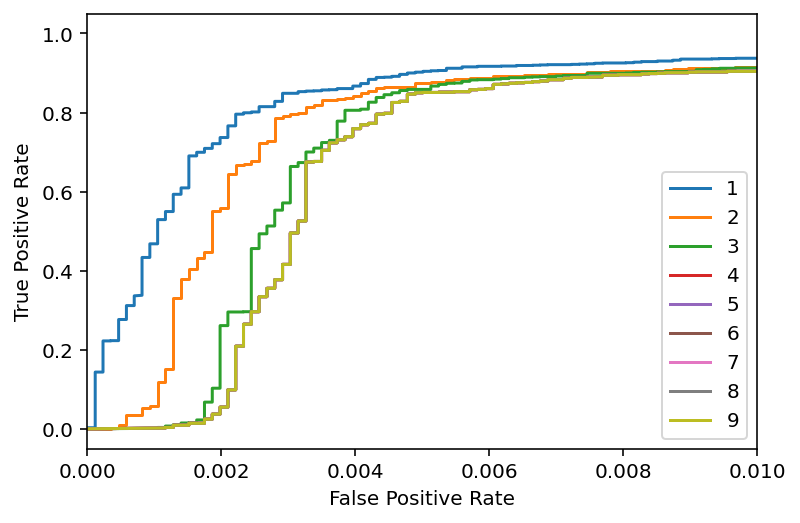

In [14]:
# Taking code from lecture 19
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

num_features = Xtrain.shape[1]
a=[]
feat=[]
# Iterate through fitting the model with increasing number of features
for i in range(1, 10):
    # Select the first 'i' features
    Xtrain_subset = Xtrain[:, :i]
    Xtest_subset = Xtest[:, :i]

    # Create and fit the GNB model
    gnb = GaussianNB()
    gnb.fit(Xtrain_subset, ytrain)

    # Make predictions
    y_pred = gnb.predict(Xtest_subset)
    y_prob = gnb.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model 
    accuracy = (y_pred == ytest).mean() #in this case I am using accuracy
    a.append(accuracy)
    feat.append(i)
    #get the roc curve
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    precision, recall, thresh2 = precision_recall_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=i
    #plot
    plt.plot(fpr, tpr,label=i)
    
    

plt.xlim(0,.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Text(0, 0.5, 'Accuaracy')

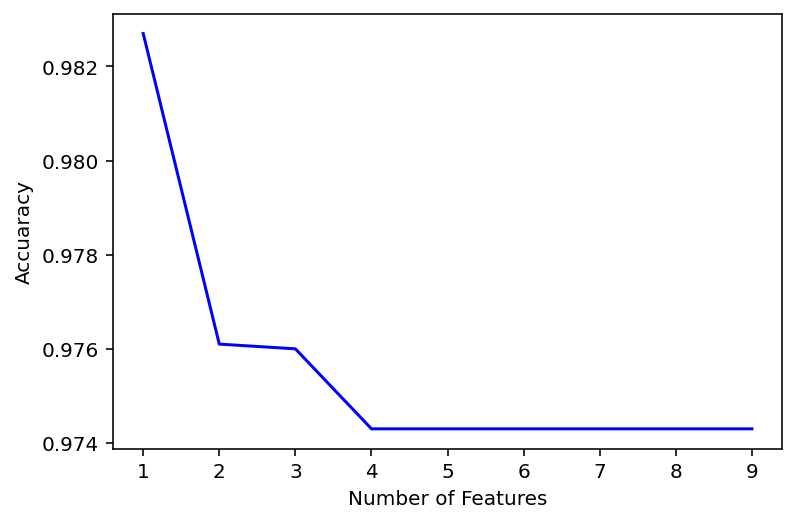

In [15]:
#plotting accuracy
plt.plot(feat,a,color='b')
plt.xlabel("Number of Features")
plt.ylabel("Accuaracy")

Trivial if we pick 1 feature.

## Part 5

In [16]:
#repeat for Quadratic Discriminant Analysis.

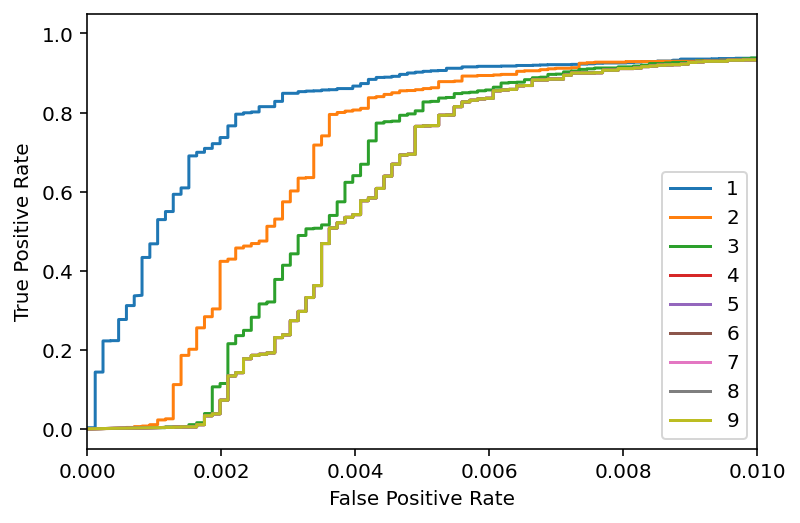

In [18]:
# Taking code from lecture 19
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

num_features = Xtrain.shape[1]
a=[]
feat=[]
#same loopo
for i in range(1, 10):
    # Select the first 'i' features
    Xtrain_subset = Xtrain[:, :i]
    Xtest_subset = Xtest[:, :i]

    # Create and fit the quadratic dis analy
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(Xtrain_subset, ytrain)

    # Make predictions
    y_pred = clf.predict(Xtest_subset)
    y_prob = clf.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model 
    accuracy = (y_pred == ytest).mean()
    a.append(accuracy)
    feat.append(i)
    #roc
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    precision, recall, thresh2 = precision_recall_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=i
    plt.plot(fpr, tpr,label=i)
    
    
#print("Accuracy with", i, "features:",accuracy)
plt.xlim(0,.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Text(0, 0.5, 'Accuaracy')

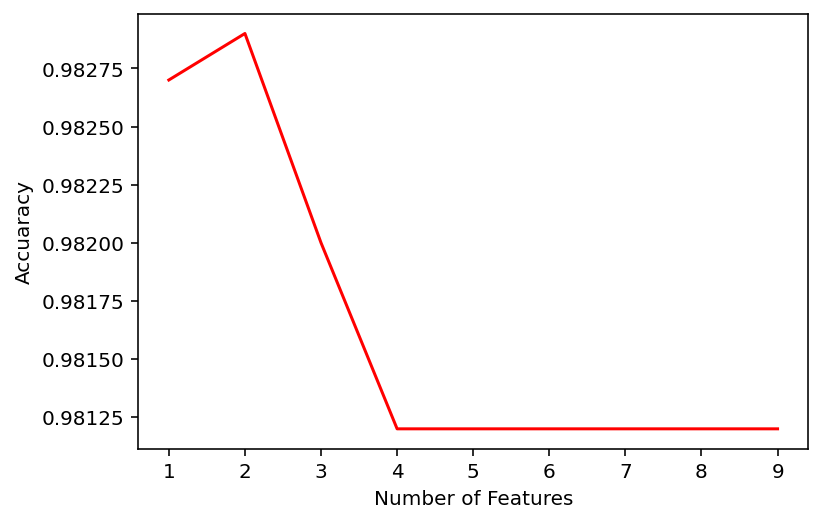

In [19]:
#plotting accuracy
plt.plot(feat,a,color='r')
plt.xlabel("Number of Features")
plt.ylabel("Accuaracy")

This model picks out two features as the prefered choice. 

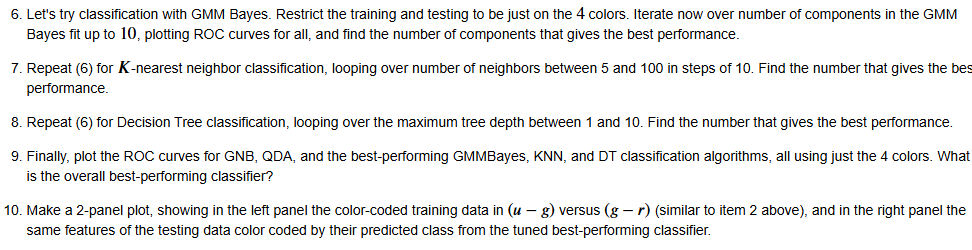

## Part 6

In [40]:
#splitting the data
#stacking 
#colors1=np.array(np.meshgrid(ug,gr)).T.reshape(-1,2)
colors = np.vstack((ug, gr, ri, iz)).T
#print(colors)
#create array
lables=[]
for i in range(len(specs)):
    if specs[i]=="QSO":
        lables.append(1)
    else:
        lables.append(0)
#print(lables)
from astroML.utils import split_samples
X=colors
#y=lables
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [.8,.2])
#print(Xtrain)

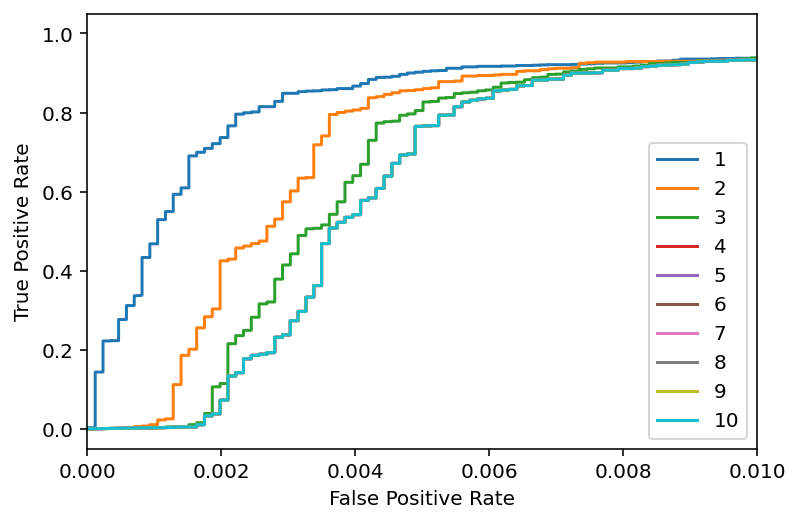

In [64]:
#taken from lecture 19
from astroML.classification import GMMBayes
a=[]
feat=[]
for i in range(1, 11):
    # Select the first 'i' components
    Xtrain_subset = Xtrain[:, :i]
    Xtest_subset = Xtest[:, :i]

    # Create and fit the GMM bayes
    clf = GMMBayes()
    clf.fit(Xtrain_subset, ytrain)

    # Make predictions
    y_pred = clf.predict(Xtest_subset)
    y_prob = clf.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model 
    accuracy = (y_pred == ytest).mean()
    a.append(accuracy)
    feat.append(i)
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=i
    plt.plot(fpr, tpr,label=i)
        

plt.xlim(0,.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Text(0, 0.5, 'Accuaracy')

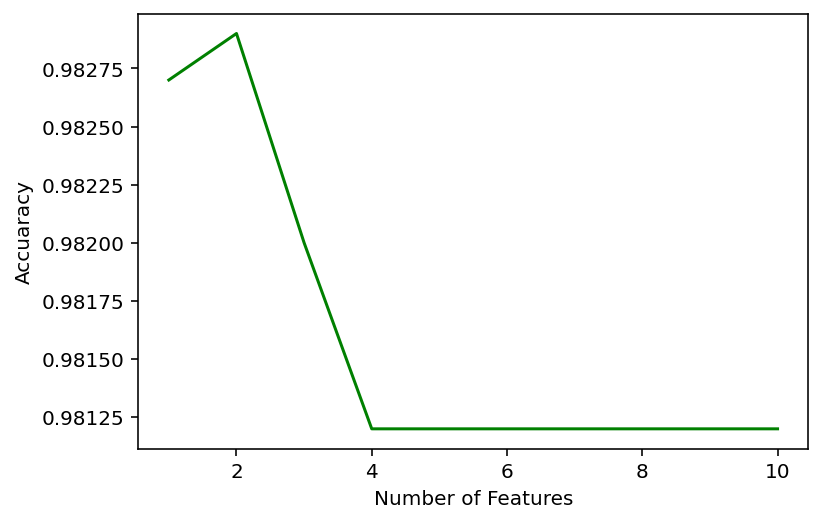

In [66]:
#plotting accuracy
plt.plot(feat,a,color='g')
plt.xlabel("Number of Features")
plt.ylabel("Accuaracy")

Best performance with 2 component.

## Part 7

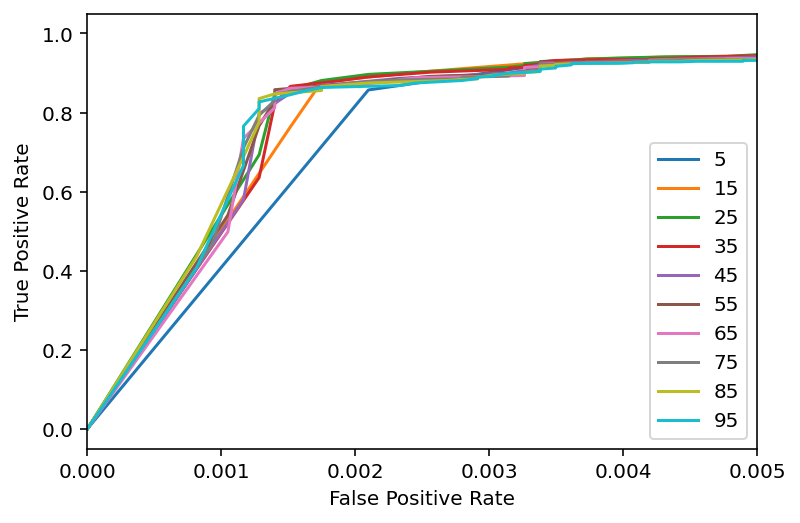

In [81]:
#again lecture 19
from sklearn.neighbors import KNeighborsClassifier
classifiers = []
predictions = []
Ncolors = np.arange(1, 5)
kvals = [5,15,25,35,45,55,65,75,85,95]
#print(kvals)
a=[]
feat=[]
for k in kvals:
# Select the first k neihbors
    
    Xtrain_subset = Xtrain
    Xtest_subset = Xtest

    # Create and fit the KNN
    clf = KNeighborsClassifier(k)
    clf.fit(Xtrain_subset, ytrain)

    # Make predictions
    y_pred = clf.predict(Xtest_subset)
    y_prob = clf.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model 
    accuracy = (y_pred == ytest).mean()
    a.append(accuracy)
    feat.append(k)
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=5
    plt.plot(fpr, tpr,label=k)
        

plt.xlim(0,.005)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

[9 8 5 7 6 4 3 0 1 2]
25


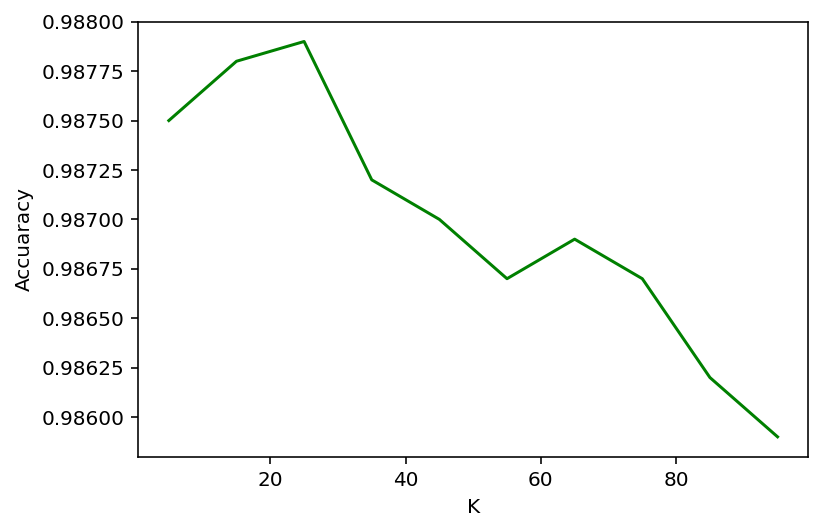

In [84]:
#plotting accuracy
plt.plot(feat,a,color='g')
plt.xlabel("K")
plt.ylabel("Accuaracy")
print(np.argsort(a))
print(feat[2])

The best performance is 25 neighbors.

## Part 8

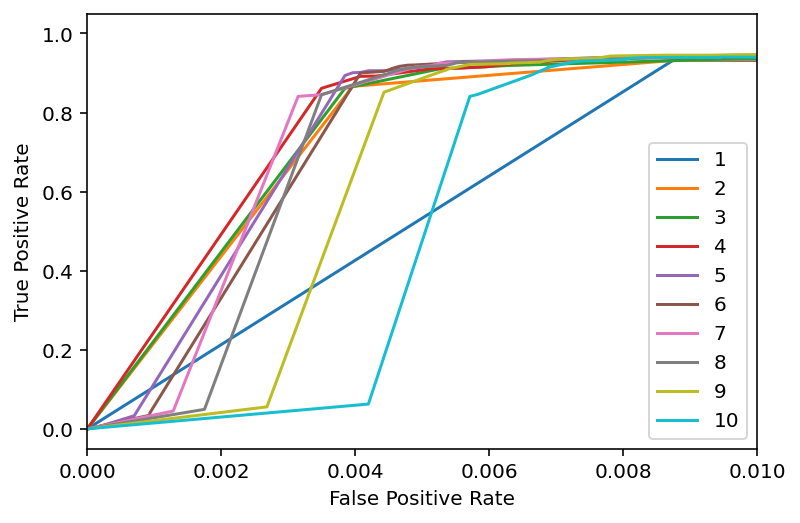

In [87]:
#decision tree
#from lecture 20
from sklearn.tree import DecisionTreeClassifier
classifiers = []
predictions = []
Ncolors = np.arange(1, 5)
kvals = [5,15,25,35,45,55,65,75,85,95]
#print(kvals)
a=[]
feat=[]
#go through k layers
for k in range(1,11):

    
    Xtrain_subset = Xtrain
    Xtest_subset = Xtest

    # Create and fit the DTC
    tree = DecisionTreeClassifier(max_depth=k)
    tree.fit(Xtrain_subset, ytrain)

    # Make predictions
    y_pred = tree.predict(Xtest_subset)
    y_prob = tree.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model (replace with your evaluation metric)
    accuracy = (y_pred == ytest).mean()
    a.append(accuracy)
    feat.append(k)
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=5
    plt.plot(fpr, tpr,label=k)
        

plt.xlim(0,.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

[0 1 2 9 3 7 8 5 6 4]
5


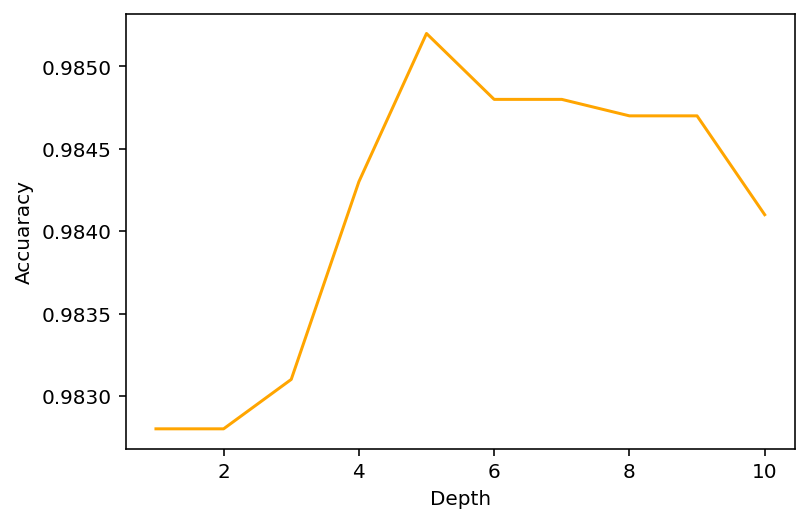

In [89]:
#plotting accuracy
plt.plot(feat,a,color='orange')
plt.xlabel("Depth")
plt.ylabel("Accuaracy")
print(np.argsort(a))
print(feat[4])

A depth of 5 appears to perfrom the best.

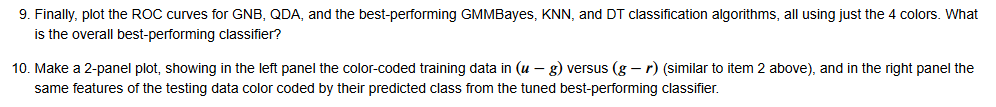

## Part 9

C:\Users\zachz\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


GaussianNB
QuadraticDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


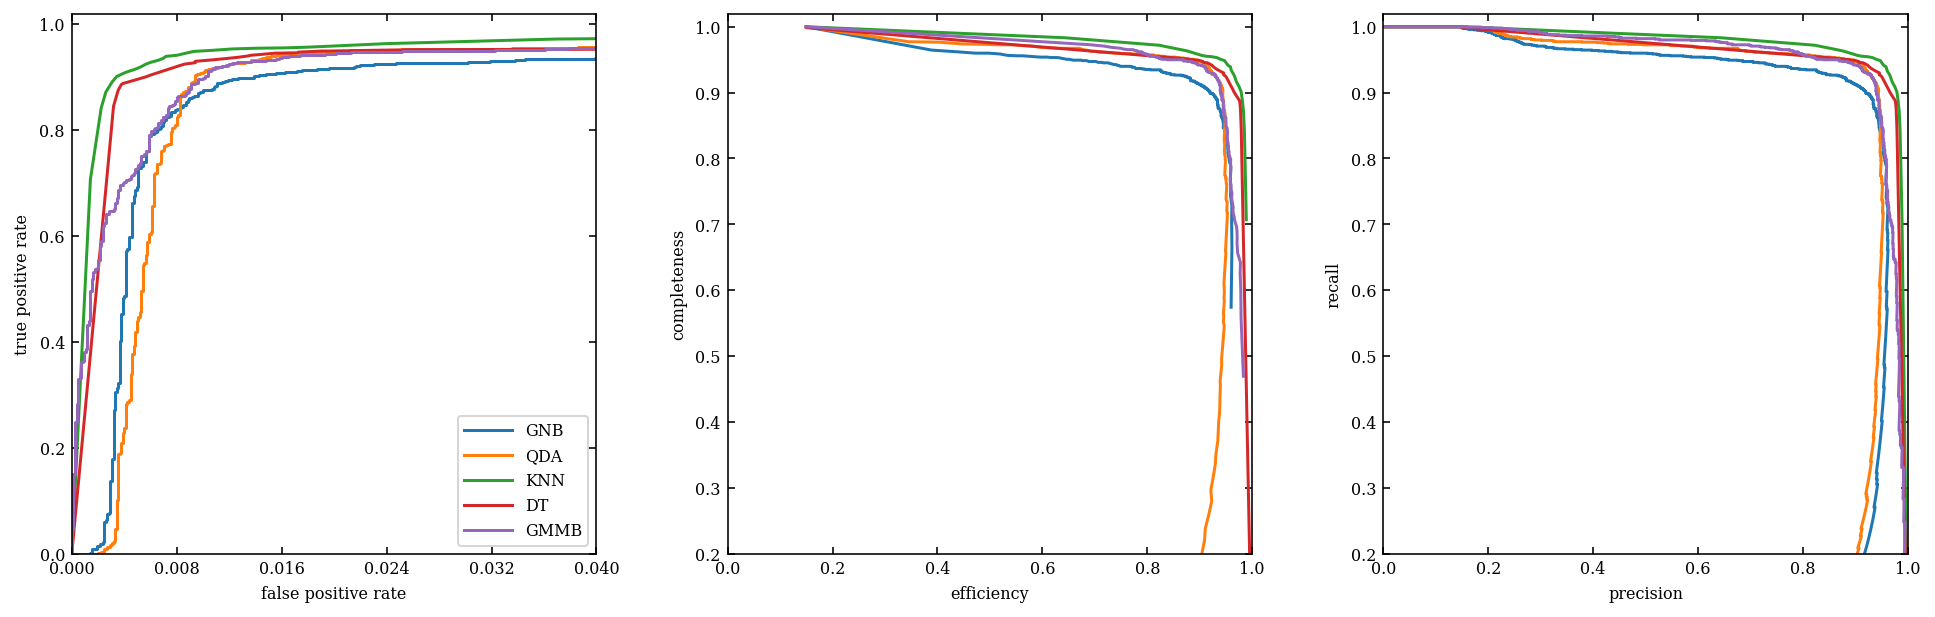

In [90]:
#adapting the lecture code
from __future__ import print_function
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined

# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

#list out best of each classifier that we want to compare
names, probs = compute_models((GaussianNB, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=25)),
                              (DecisionTreeClassifier,
                               dict( max_depth=5)),
                              (GMMBayes, dict(n_components=2)))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

# ax3 will show precision/recall
ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    
    ax3.plot(precision, recall, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

ax3.set_xlabel('precision')
ax3.set_ylabel('recall')
ax3.set_xlim(0, 1.0)
ax3.set_ylim(0.2, 1.02)

plt.show()

The best perfomer is KNN!

## Part 10

In [144]:
#1 same as HW3
#read in the data
data=np.load('../../../homeworks/hw_data/hw8_data_1.npy')
#get the coulumn names
c = data.dtype.names
print(c)
#u-g
ug=np.subtract(data['u'],data['g'])
#g-r
gr=np.subtract(data['g'],data['r'])
#r-i
ri=np.subtract(data['r'],data['i'])
#i-z
iz=np.subtract(data['i'],data['z'])
#redshift
red=data['redshift']
rederr=data['redshift_err']
#spectral
specs=data['specClass']
#print(spec)

#counting 
count1=0
for i in range(len(specs)):
    if specs[i]=="QSO":
        count1+=1
print('There are',count1,'QSO')

count2=0
for i in range(len(specs)):
    if specs[i]=="GALAXY":
        count2+=1
print('There are',count2,'Galaxies')
colors = np.vstack((ug, gr)).T
lables=[]
for i in range(len(specs)):
    if specs[i]=="QSO":
        lables.append(1)
    else:
        lables.append(0)

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
There are 7192 QSO
There are 42808 Galaxies


<function matplotlib.pyplot.show(close=None, block=None)>

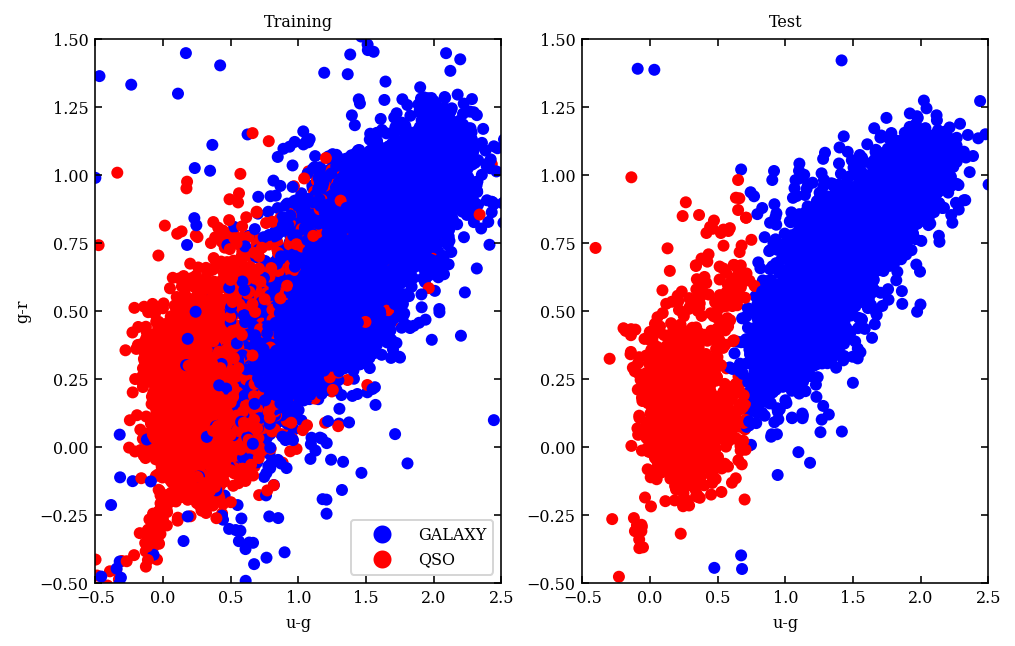

In [157]:
# Color mapping
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
color_map = {'GALAXY': 'blue', 'QSO': 'red'}
#plotting 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 5)) #set up plot

#ax2.scatter(y,label,color="C2")#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 

#predict label
X = colors
y=specs
(Xtrain, Xtest), (ytrain, ytest) = split_samples(X, y, [.8,.2])
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(25) # use best nearest neighbors
knc.fit(Xtrain,ytrain)

preds = knc.predict(Xtest)

#plotting
ax1.scatter(Xtrain[:,0], Xtrain[:,1], c=[color_map[y] for y in ytrain],ec='none')#loc="lower right"
ax2.scatter(Xtest[:,0], Xtest[:,1], c=[color_map[pred] for pred in preds],ec='none')#loc="lower right"

ax1.legend( handles=legend_elements)
ax1.set_title("Training")
ax2.set_title("Test")
ax1.set_ylabel("g-r")
ax1.set_xlabel("u-g")
ax2.set_xlabel("u-g")
ax1.set_xlim(-.5,2.5)
ax1.set_ylim(-.5,1.5)
ax2.set_xlim(-.5,2.5)
ax2.set_ylim(-.5,1.5)
plt.show


Now for the full dataset.

<function matplotlib.pyplot.show(close=None, block=None)>

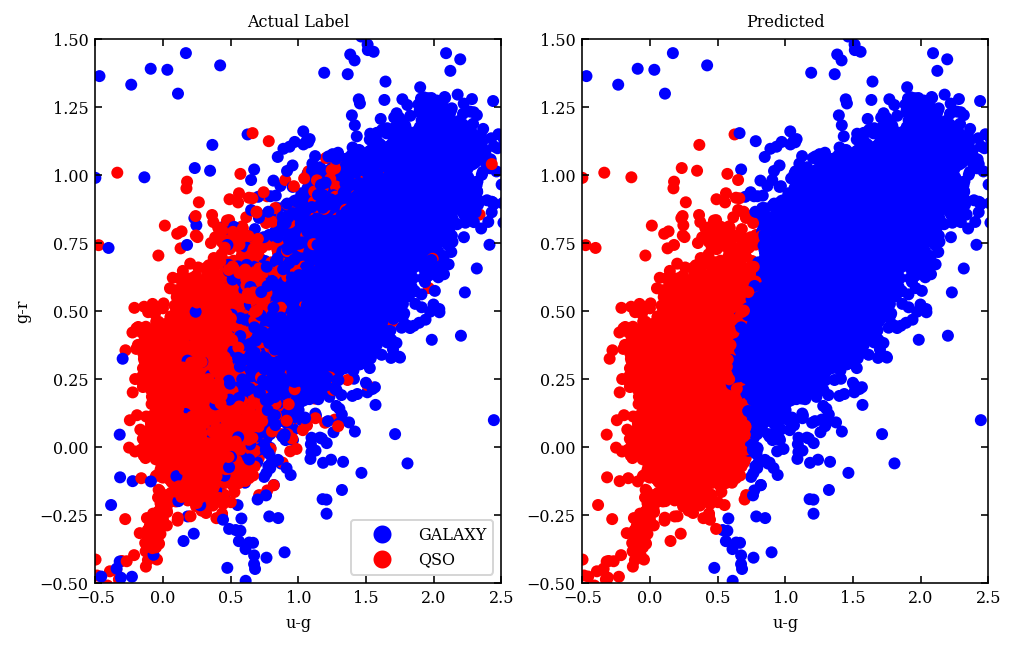

In [150]:
# Color mapping
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
color_map = {'GALAXY': 'blue', 'QSO': 'red'}
#plotting 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 5)) #set up plot
ax1.scatter(ug, gr, c=[color_map[spec] for spec in specs],ec='none')#loc="lower right"
#ax2.scatter(y,label,color="C2")#loc="lower right"
#C0 blue,C1 orange,C2 GREEN, C3 red, C4 weak purple 

#predict label
X = colors
y=specs
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [.8,.2])
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(25) # use best nearest neighbors
knc.fit(X,y)

preds = knc.predict(X)

#plotting
ax2.scatter(ug, gr, c=[color_map[pred] for pred in preds],ec='none')#loc="lower right"

ax1.legend( handles=legend_elements)
ax1.set_title("Actual Label")
ax2.set_title("Predicted")
ax1.set_ylabel("g-r")
ax1.set_xlabel("u-g")
ax2.set_xlabel("u-g")
ax1.set_xlim(-.5,2.5)
ax1.set_ylim(-.5,1.5)
ax2.set_xlim(-.5,2.5)
ax2.set_ylim(-.5,1.5)
plt.show

<span style="color:green">NP: Correct! Good job!</span>